<a href="https://colab.research.google.com/github/jjangmo91/eeSDM_Cervus-nippon/blob/main/eeSDM_Cervus_nippon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **eeSDM_Cervus-nippon**
이 프로젝트는 Google Earth Engine과 Google Colab을 활용하여 대만꽃사슴(Cervus nippon)의 종분포모델링(Species Distribution Modeling, SDM)을 수행하는 프로젝트입니다. 이 프로젝트는 속리산국립공원에 분포하는 침입종인 대만꽃사슴의 현재 및 미래 서식 가능 지역을 예측하고, 이를 통해 국립공원공단의 생태계 보존 전략 수립에 기여하고자 합니다.


데이터 분석에 필요한 라이브러리와 패키지를 설치하고, 불러옵니다.

In [1]:
%pip install -U -q eeSDM
%pip install -U -q pyarrow
%pip install -U -q geopandas
%pip install -U -q pycrs
%pip install -U -q statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 18.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import eeSDM
import ee, geemap
import geemap.colormaps as cm

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import random, math, os

from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Earth Engine Authentication
ee.Authenticate()

# Initializing Earth Engine
ee.Initialize(project='ee-jjangmo91')

# 1. Add Species Occurrence Data(Local)
종 발생 데이터(로컬) 추가 및 지리적 샘플링 편향 제거
여기서는 데이터 수 부족으로, 일반적인 데이터 전처리 방법인 결측값 처리, 이상치 제거, 정규화 등의 과정을 생략했습니다.

In [4]:
# CSV 파일 경로
url = "https://raw.githubusercontent.com/jjangmo91/eeSDM_Cervus-nippon/main/Cervus-nippon.csv"

# DataFrame 변환
df = pd.read_csv(url)
print(df.columns)

# GeoDataFrame 변환
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs = "EPSG:4326")

# GeoDataFrame을 Earth Engine 객체로 변환
data_raw = geemap.geopandas_to_ee(gdf)

# 공간 해상도 설정(m)
grainsize = 30

# Geographic sampling bias 제한(하나 빼고 다 제거)

def remove_duplicates(data_raw, grainsize):
    # Select one occurrence record per pixel at the chosen spatial resolution
    # Generate a random raster image and reproject it to the specified coordinate system and resolution
    random_raster = ee.Image.random().reproject('EPSG:4326', None, grainsize)

    # Sample presence points with the generated random raster
    # Scale parameter is set to 10 for sampling, geometries are included
    rand_point_vals = random_raster.sampleRegions(collection=ee.FeatureCollection(data_raw), geometries=True)

    # Keep only distinct presence records based on the 'random' property
    return rand_point_vals.distinct('random')

data = remove_duplicates(data_raw, grainsize)

Index(['Species', 'Latitude', 'Longitude'], dtype='object')


지리적 샘플링 편향을 전처리 전(파란색)과 전처리 후(빨간색)로 비교한 시각화는 아래와 같습니다. 비교를 용이하게 하기 위해, 지도는 속리산국립공원에서 외래꽃사슴 발생 좌표가 많이 집중된 지역을 중심으로 설정되었습니다.

In [5]:
# Visualization of geographic sampling bias before (blue) and after (red) preprocessing
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

# Add the random raster layer
random_raster = ee.Image.random().reproject("EPSG:4326", None, grainsize)
Map.addLayer(
    random_raster,
    {"min": 0, "max": 1, "palette": ["black", "white"], "opacity": 0.5},
    "Random Raster",
)

# Add the original data layer in blue
Map.addLayer(data_raw, {"color": "blue"}, "Original data")

# Add the final data layer in red
Map.addLayer(data, {"color": "red"}, "Final data")

# Set the center of the map to the coordinates
Map.centerObject(data.geometry(), 12)
Map

Map(center=[36.554703162575194, 127.8572837211205], controls=(WidgetControl(options=['position', 'transparent_…

종 출현자료?Presence? Occureance? (정의/논문 찾기)

/ 자료를 학습데이터와 테스트데이터로 나눕니다.
비율 찾아보고 설정하기? k-fold-validation(정의/논문 찾기)

머신러닝 모델의 성능을 높이기 위해(과적합 방지) 교차 검증을 수행합니다. 학습 데이터셋(train set)과 테스트 데이터셋(test set)으로 나눕니다. // 어떤 메서드 사용할지 찾아봐야 함

test set을 가지고만 모델의 성능을 확인하고, 파라미터를 수정하고 이 과정을 반복하면 머신러닝에서 test set만 학습하여, 실제의 다른 데이터를 가지고 예측을하게 되면 overfitting의 문제가 발생하게 되므로 과적합 방지를 위해 교차 검증이 필요함

교차검증?
+ 주어진 데이터셋에 학습된 알고리즘이 얼마나 잘 일반화되어있는지 평가하기 위한 방법

+ 데이터를 여러 번 반복해서 나누고 여러 번 모델 학습과 검증 과정을 거침, 데이터셋 내의 모든 데이터를 훈련에 활용할 수 있으며, 모델 성능과 정확도를 더 향상시킬 수 있음, 좀 더 일반화된 모델을 만들 수 있음.

+ 부족한 데이터로인한 underfittting을 방지할 수 있고, test set이 편중되는 것을 방지할 수 있음

교차검증 방법도 종류가 많음
대표적인 것은 k-fold cross validation
이 외에 stratified k-kold cross validation 등이 있음

train set를 k개의 fold set로 만들어주고
k개의 fold set를 train set과 validation set로 나누게 됨
k-1개를 train set, 1개를 validation set으로 설정하여 검증 평가를 진행, k개의 fold set에 대해 차례로 validation set을 변경하여 k번의 검증을 수행 함

모델을 학습한 뒤, k번의 성능 평가 결과를 평균하여 최종 모델 성능을 구함






In [ ]:
# K-fold-validation

# 2. Define Area of Interest (AOI)

In [6]:
# Define the AOI
aoi = data.geometry().bounds().buffer(distance=50000, maxError=1000)

# Add the AOI to the map
outline = ee.Image().byte().paint(
    featureCollection=aoi, color=1, width=3)

Map.remove_layer("Random Raster")
Map.addLayer(outline, {'palette': 'FF0000'}, "AOI")
Map.centerObject(aoi, 7)
Map

Map(bottom=409957.0, center=[36.52971161769407, 127.85645081415713], controls=(WidgetControl(options=['positio…

# 3. Add Predictive Variables
환경 변수 이것 저것 더 만들어야 함...
박사님들한테 물어보기

In [7]:
# WorldClim BIO Variables V1 (1km): A total of 19 climate variables
BIO = ee.Image("WORLDCLIM/V1/BIO")

# NASA SRTM Digital Elevation 30m: Digital elevation data
Terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))

# MOD44B.006 Terra MODIS Vegetation Continuous Fields Yearly Global 250m
# Percent Tree Cover: Median between 2003 and 2020
MODIS = ee.ImageCollection("MODIS/006/MOD44B")
MedianPTC = MODIS.filterDate('2003-01-01', '2020-12-31').select(['Percent_Tree_Cover'], ['PTC']).median()

# TCC / Global Forest Cover Change(GFCC)
TCC = ee.ImageCollection("NASA/MEASURES/GFCC/TC/v3")
MedianTCC = TCC.filterDate('2000-01-01', '2015-12-31')
MedianTCC = MedianTCC.select(['tree_canopy_cover'], ['TCC']).median()

# Combining Bands into a Single Multi-Band Image
predictors = BIO.addBands(Terrain).addBands(MedianPTC).addBands(MedianTCC)

# 수역 마스크 생성
watermask =  Terrain.select('elevation').gt(0)

# 해양 픽셀 마스킹 및 관심 영역 클리핑
predictors = predictors.updateMask(watermask).clip(aoi)



모델에 높은 상관관계를 가진 예측 변수가 함께 포함되면 다중공선성 문제가 발생할 수 있습니다. 다중공선성은 모델의 독립 변수들 간에 강한 선형 관계가 있을 때 발생하는 현상으로, 모델 계수(가중치) 추정의 불안정을 초래합니다. 이러한 불안정성은 모델의 신뢰성을 감소시키고, 새로운 데이터에 대한 예측이나 해석을 어렵게 만들 수 있습니다. 따라서 우리는 다중공선성을 고려하고 예측 변수를 선택하는 과정을 진행할 것입니다.먼저, 5,000개의 무작위 점을 생성한 후, 해당 지점에서 단일 멀티밴드 이미지의 예측 변수 값을 추출할 것입니다.

In [8]:
# Generate 5,000 random points
data_cor = predictors.sample(scale=grainsize, numPixels=5000, geometries=True)

# Extract predictor variable values
pvals = predictors.sampleRegions(collection=data_cor, scale=grainsize)

추출된 예측 변수 값을 각 포인트에 대해 DataFrame으로 변환한 후 첫 번째 행을 확인할 것입니다.

In [9]:
# Converting predictor values from Earth Engine to a DataFrame
pvals_df = geemap.ee_to_df(pvals)
pvals_df.head(1)

# Displaying the columns
columns = pvals_df.columns
print(columns)

Index(['PTC', 'TCC', 'aspect', 'bio01', 'bio02', 'bio03', 'bio04', 'bio05',
       'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13',
       'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'elevation',
       'hillshade', 'slope'],
      dtype='object')


주어진 예측 변수들 간의 스피어만 상관 계수를 계산하고, 이를 히트맵으로 시각화합니다. / 상관관계를 분석하는 방법은 여러가지가 있음, Pearson, Spearman, Kendall's tau 등 여기서 필요한 독립변수 선택, 그리고 fearture 변환과 연계하여 수정 필요

In [10]:
def plot_correlation_heatmap(dataframe, h_size=10, show_labels=False):
    # Calculate Spearman correlation coefficients
    correlation_matrix = dataframe.corr(method="spearman")

    # Create a heatmap
    plt.figure(figsize=(h_size, h_size-2))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

    # Optionally display values on the heatmap
    if show_labels:
        for i in range(correlation_matrix.shape[0]):
            for j in range(correlation_matrix.shape[1]):
                plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                         ha='center', va='center', color='white', fontsize=8)

    columns = dataframe.columns.tolist()
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.title("Variables Correlation Matrix")
    plt.colorbar(label="Spearman Correlation")
    plt.savefig('correlation_heatmap_plot.png')
    plt.show()

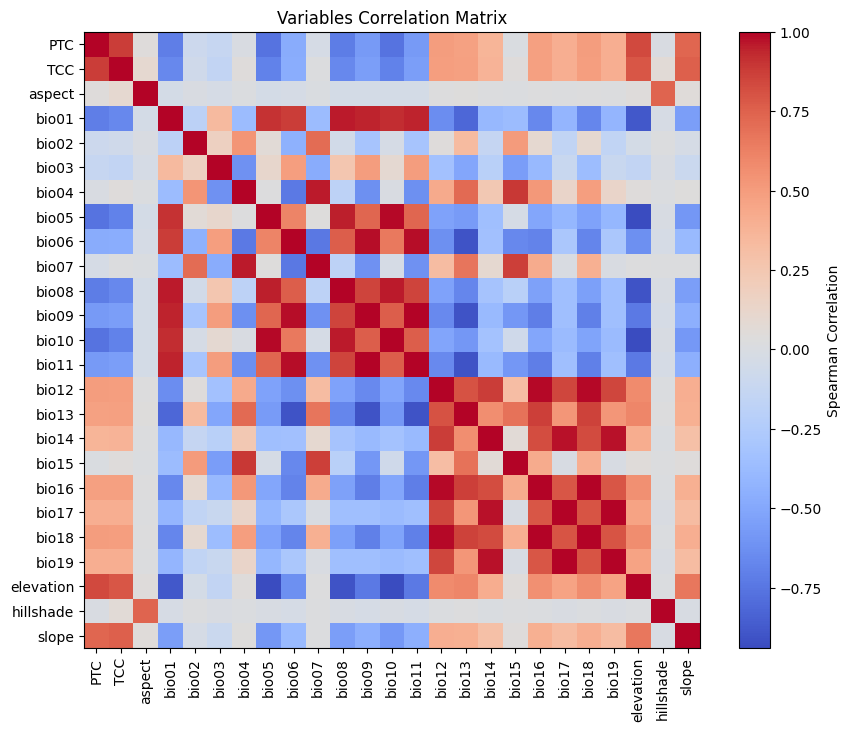

In [11]:
# Plot the correlation heatmap of variables
plot_correlation_heatmap(pvals_df)

스피어만 상관 계수는 예측 변수들 간의 일반적인 연관성을 이해하는 데 유용하지만, 다중공선성을 구체적으로 감지하는 것과는 다르게 여러 변수들의 상호작용을 직접적으로 평가하지는 않습니다.분산 팽창 계수(Variance Inflation Factor, VIF)는 다중공선성을 평가하고 변수 선택을 안내하는 데 사용되는 통계적 지표입니다. VIF는 각 독립 변수가 다른 독립 변수들과 얼마나 선형적으로 연관되어 있는지를 나타내며, 높은 VIF 값은 다중공선성의 증거가 될 수 있습니다.일반적으로 VIF 값이 5 또는 10을 초과하면 해당 변수가 다른 변수들과 강한 상관관계를 가지며, 이는 모델의 안정성과 해석 가능성을 저해할 수 있음을 시사합니다. 여기서는 VIF 값이 10 미만인 변수를 선택하는 기준을 사용했습니다.

In [12]:
# Filter variables based on Variance Inflation Factor (VIF)
def filter_variables_by_vif(dataframe, threshold=10):

    original_columns = dataframe.columns.tolist()
    remaining_columns = original_columns[:]

    while True:
        vif_data = dataframe[remaining_columns]
        vif_values = [
            variance_inflation_factor(vif_data.values, i)
            for i in range(vif_data.shape[1])
        ]

        max_vif_index = vif_values.index(max(vif_values))
        max_vif = max(vif_values)

        if max_vif < threshold:
            break

        print(f"Removing '{remaining_columns[max_vif_index]}' with VIF {max_vif:.2f}")

        del remaining_columns[max_vif_index]

    filtered_data = dataframe[remaining_columns]
    bands = filtered_data.columns.tolist()
    print("Bands:", bands)

    return filtered_data, bands

In [13]:
filtered_pvals_df, bands = filter_variables_by_vif(pvals_df)

Removing 'bio05' with VIF inf
Removing 'bio09' with VIF inf
Removing 'bio17' with VIF inf
Removing 'bio04' with VIF 556350.98
Removing 'bio16' with VIF 526499.61
Removing 'bio07' with VIF 254798.29
Removing 'bio10' with VIF 154513.61
Removing 'bio12' with VIF 101329.32
Removing 'bio08' with VIF 33280.74
Removing 'bio15' with VIF 22869.44
Removing 'bio02' with VIF 18521.73
Removing 'bio19' with VIF 5157.35
Removing 'bio18' with VIF 4208.87
Removing 'bio06' with VIF 3711.35
Removing 'bio13' with VIF 1906.90
Removing 'bio03' with VIF 1462.91
Removing 'bio14' with VIF 121.91
Removing 'hillshade' with VIF 41.18
Removing 'PTC' with VIF 21.39
Removing 'elevation' with VIF 11.24
Bands: ['TCC', 'aspect', 'bio01', 'bio11', 'slope']


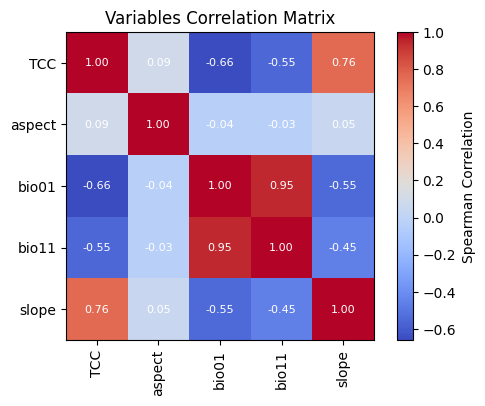

In [14]:
# Variable Selection Based on VIF
predictors = predictors.select(bands)

# Plot the correlation heatmap of variables
plot_correlation_heatmap(filtered_pvals_df, h_size=6, show_labels=True)

다음으로, 선택된 예측 변수를 지도에 시각화해봅니다.

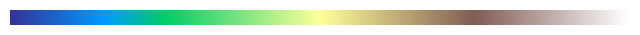

In [15]:
cm.plot_colormap('terrain', width=8.0, height=0.2, orientation='horizontal')

In [16]:
# Calculate the minimum and maximum values for bio01
min_max_val = (
    predictors.select("bio01")
    .multiply(0.1)
    .reduceRegion(reducer=ee.Reducer.minMax(), scale=1000)
    .getInfo()
)

# bio01 (Mean temperature) layer
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "min": math.floor(min_max_val["bio01_min"]),
    "max": math.ceil(min_max_val["bio01_max"]),
    "palette": cm.palettes.hot,
}
Map.addLayer(predictors.select("bio01").multiply(0.1), vis_params, "bio01")
Map.add_colorbar(
    vis_params,
    label="Mean temperature of driest quarter (℃)",
    orientation="vertical",
    layer_name="bio01",
)
Map.centerObject(aoi, 8)
Map

Map(center=[36.52971161769407, 127.85645081415713], controls=(WidgetControl(options=['position', 'transparent_…

In [17]:
# Slope layer
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

vis_params = {'bands':['slope'], 'min': 0, 'max': 25, 'palette': cm.palettes.RdYlGn_r}
Map.addLayer(predictors, vis_params, 'slope')
Map.add_colorbar(vis_params, label="Slope", orientation="vertical", layer_name="slope")
Map.centerObject(aoi, 8)
Map

Map(center=[36.52971161769407, 127.85645081415713], controls=(WidgetControl(options=['position', 'transparent_…

In [18]:
# Aspect layer
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

vis_params = {'bands':['aspect'], 'min': 0, 'max': 360, 'palette': cm.palettes.rainbow}
Map.addLayer(predictors, vis_params, 'aspect')
Map.add_colorbar(vis_params, label="Aspect", orientation="vertical", layer_name="aspect")
Map.centerObject(aoi, 8)
Map

Map(center=[36.52971161769407, 127.85645081415713], controls=(WidgetControl(options=['position', 'transparent_…

In [19]:
# TCC layer
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "bands": ["TCC"],
    "min": 0,
    "max": 100,
    "palette": ["ffffff", "afce56", "5f9c00", "0e6a00", "003800"],
}
Map.addLayer(predictors, vis_params, "TCC")
Map.add_colorbar(
    vis_params, label="Tree Canopy Cover (%)", orientation="vertical", layer_name="TCC"
)
Map.centerObject(aoi, 8)
Map


Map(center=[36.52971161769407, 127.85645081415713], controls=(WidgetControl(options=['position', 'transparent_…

# 4. Input data 선택 Presence-Background(MaxEnt)
SDM은 여러가지 접근 방법이 있습니다. 여기서는 Presence only models로 Presence/background 모델 적합 및 해석 방식인 Maxent를 사용합니다. / 이거 오늘안에 해결하고 고쳐놓기

In [20]:
# Add a property indicating presence
species_points = species_points.map(lambda feature: feature.set('presence', 1))

# Create background points
background_points = ee.FeatureCollection.randomPoints(
    region=species_points.geometry().bounds(),
    points=500,  # Number of background points
    seed=42
).map(lambda feature: feature.set('presence', 0))

# Combine species occurrence points with background points
combined_points = species_points.merge(background_points)

# Sample the environmental data at the presence and background points
training_data = climate_data.sampleRegions(
    collection=combined_points,
    properties=['presence'],
    scale=30
)

# Create some sample species presence/absence training data.
training_data = ee.FeatureCollection([
    # Species present points.
    ee.Feature(ee.Geometry.Point([-122.39567, 38.02740]), {'presence': 1}),
    ee.Feature(ee.Geometry.Point([-122.68560, 37.83690]), {'presence': 1}),
    # Species absent points.
    ee.Feature(ee.Geometry.Point([-122.59755, 37.92402]), {'presence': 0}),
    ee.Feature(ee.Geometry.Point([-122.47137, 37.99291]), {'presence': 0}),
    ee.Feature(ee.Geometry.Point([-122.52905, 37.85642]), {'presence': 0}),
    ee.Feature(ee.Geometry.Point([-122.03010, 37.66660]), {'presence': 0})
])

NameError: name 'species_points' is not defined

In [ ]:
# 100개의 출현 위치 무작위로 선택
PixelVals = predictors.sampleRegions(
    collection=Data.randomColumn().sort('random').limit(100),
    properties=[],
    tileScale=16,
    scale=GrainSize
)

In [ ]:
# k-means 클러스터링
clusterer = ee.Clusterer.wekaKMeans(
    nClusters=2,
    distanceFunction="Euclidean"
).train(PixelVals)

Clresult = predictors.cluster(clusterer)

# 출현 위치와 유사한 클러스터 ID
clustID = Clresult.sampleRegions(
    collection=Data.randomColumn().sort('random').limit(200),
    properties=[],
    tileScale=16,
    scale=GrainSize
)

# 유사하지 않은 클러스터에서 임의-비출현 영역 정의
clustID = ee.FeatureCollection(clustID). \
reduceColumns(ee.Reducer.mode(),['cluster'])
clustID = ee.Number(clustID.get('mode')).subtract(1).abs()
cl_mask = Clresult.select(['cluster']).eq(clustID)


In [ ]:
# 출현 위치 마스크
presence_mask = Data.reduceToImage(
    properties=['random'],
    reducer=ee.Reducer.first()
).reproject('EPSG:4326', None,
            ee.Number(GrainSize)).mask().neq(1).selfMask()

AreaForPA = presence_mask.updateMask(cl_mask).clip(AOI)

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

Map.addLayer(AreaForPA, {'palette': 'black'},'AreaForPA')
Map.centerObject(AOI, 6)
Map


Map(center=[36.529621786200934, 127.85645081415706], controls=(WidgetControl(options=['position', 'transparent…

# 5. Fit SDM Model
여기서 Maxent Model 적용할 거고, 순서는 train data로 maxent 모델 구동시킨 후 변수 기여도와 반응곡선을 확인 해봄, 생성된 모델 이요해서 잠재서식지 예측해봄(plot), 모델 평가해야하는데 Pseudo absent data 생성해서 모델 평가 함, 고로 랜덤포인트 생성해서 ROC / AUC로 모델 성능 평가함, Over fitting이나 under fitting 고려해야 함

In [ ]:
def createGrid(geometry, scale):
    # 관심 지역의 경계를 기반으로 격자를 생성
    grid = ee.Image().toByte().paint(geometry, 1).reproject('EPSG:4326', None, scale)
    vectors = grid.reduceToVectors(
        geometryType='polygon',
        reducer=ee.Reducer.countEvery(),
        scale=scale,
        maxPixels=1e8,
        geometry=geometry
    )
    return vectors

Scale = 50000
grid = makeGrid(AOI, Scale)
Grid = watermask.reduceRegions(
    collection=grid,
    reducer=ee.Reducer.mean()).filter(ee.Filter.neq('mean', None))

In [ ]:
# 알고리즘 생성(랜덤포레스트)
Classifier = ee.Classifier.smileRandomForest(
        numberOfTrees=500,
        variablesPerSplit=None,
        minLeafPopulation=10,
        bagFraction=0.5,
        maxNodes=None,
        seed=Seed)

In [ ]:
split = 0.7
numiter = 10
runif = lambda length: [random.randint(1, 1000) \
                        for _ in range(length)]
items = runif(numiter)
# items = [287, 288, 553, 226, 151, 255, 902, 267, 419, 538]

# Fit SDM
results = eeSDM.batchSDM(Grid, Data, AreaForPA, GrainSize, bands, predictors, numiter, split=0.7, seed=None)

# 6. Map

In [ ]:
# 서식지 적합성 지도(Habitat suitability map)
images = ee.List.sequence(1, ee.Number(numiter).multiply(5).subtract(1), 5).map(lambda x: results.get(x))
ModelAverage = ee.ImageCollection.fromImages(images).mean()
Map = geemap.Map()
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['#440154', '#482677', '#404788', '#33638D', '#287D8E',
          '#1F968B', '#29AF7F', '#55C667', '#95D840', '#DCE319']}
Map = geemap.Map()
Map.addLayer(ModelAverage, vis_params, 'Habitat suitability')
Map.add_colorbar(vis_params, label="Habitat suitability", orientation="horizontal", layer_name="Habitat suitability")
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.centerObject(Data.geometry(), 7)
Map

EEException: No valid training data were found.

In [ ]:
# 잠재적 분포 지도(Potential distribution map)
images2 = ee.List.sequence(2, ee.Number(numiter).multiply(5).subtract(1), 5).map(lambda x: results.get(x))
DistributionMap = ee.ImageCollection.fromImages(images2).mode()

Map = geemap.Map()
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']}
Map.addLayer(DistributionMap, vis_params, 'Potential distribution')
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.add_colorbar(vis_params, label="Potential distribution", discrete=True, orientation="horizontal", layer_name="Potential distribution")
Map.centerObject(Data.geometry(), 7)
Map

EEException: No valid training data were found.

# 7. Calculate Variable Importance

In [ ]:
# Plot Average Variable Importance
eeSDM.plot_avg_variable_importance(results, numiter)

EEException: No valid training data were found.

# 8. Accuracy Assessment

In [ ]:
# Testing datasets
TestingDatasets = (ee.List.sequence(4, ee.Number(numiter).multiply(5).subtract(1), 5).map(lambda x: results.get(x)))

# Checking if there are sufficient presence and pseudo-absence points
eeSDM.print_pres_abs_sizes(TestingDatasets, numiter)

EEException: No valid training data were found.

In [ ]:
%%time

# Calculate AUC-ROC and AUC-PR
eeSDM.calculate_and_print_auc_metrics(images, TestingDatasets, GrainSize, numiter)

In [ ]:
%%time

# Calculate Sensitivity and Specificity
eeSDM.calculate_and_print_ss_metrics(images, TestingDatasets, GrainSize, numiter)

In [ ]:
%%time

# Plot ROC and PR curves
eeSDM.plot_roc_pr_curves(images, TestingDatasets, GrainSize, numiter)

In [ ]:
%%time

# Potential Distribution Map using the optimal threshold
DistributionMap2 = eeSDM.create_DistributionMap2(images, TestingDatasets, GrainSize, numiter, ModelAverage)

In [ ]:
out_dir = 'D:/GEODATA'

# Save Habitat Suitability Map as GeoTIFF
out_file = os.path.join(out_dir, 'habitat_suitability.tif')
geemap.ee_export_image(ModelAverage, filename=out_file, region=AOI, scale=1000)

# Save Potential Distribution Map as GeoTIFF
out_file = os.path.join(out_dir, 'distribution_map.tif')
geemap.ee_export_image(DistributionMap, filename=out_file, region=AOI, scale=1000)

# Save Potential Distribution Map with Optimal Threshold as GeoTIFF
out_file = os.path.join(out_dir, 'distribution_map2.tif')
geemap.ee_export_image(DistributionMap2, filename=out_file, region=AOI, scale=1000)